In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/california-house-prices24/housing_test.csv
/kaggle/input/california-house-prices24/housing_test_sample_solution.csv
/kaggle/input/california-house-prices24/housing_train.csv


In [6]:
data=pd.read_csv("/kaggle/input/california-house-prices24/housing_train.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-116.46,33.82,6.0,4863.0,920.0,3010.0,828.0,3.9508,104200.0,INLAND
1,-117.04,34.00,21.0,4624.0,852.0,2174.0,812.0,3.5255,132100.0,INLAND
2,-121.03,37.55,32.0,946.0,198.0,624.0,173.0,1.9728,97900.0,INLAND
3,-117.80,33.68,8.0,2032.0,349.0,862.0,340.0,6.9133,274100.0,<1H OCEAN
4,-122.26,37.83,52.0,1656.0,420.0,718.0,382.0,2.6768,182300.0,NEAR BAY


In [7]:
data.shape

(14448, 10)

In [8]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [9]:
data.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [72]:
from sklearn.model_selection import train_test_split

Y=data["median_house_value"]
X=data.drop(columns=["median_house_value"])

X_train , X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.3, random_state=10)

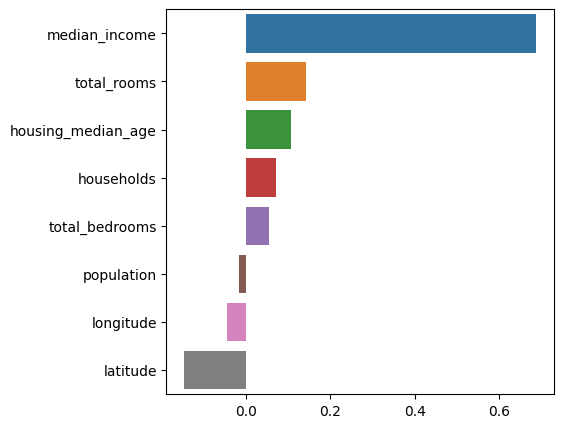

In [73]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.median()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlations = X_train[numeric_features].corrwith(Y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(5, 5)

Исходя из корреляции, мы убираем признаки population и total_bedrooms, так как данные признаки наименее лин. зависимые величины

In [98]:
Y=data["median_house_value"]
X=data.drop(columns=["median_house_value","population","total_bedrooms"])

X_train , X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.3, random_state=10)
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.median()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

Рассматриваем распределение на тестовой выборке:

/tmp/ipykernel_33/1262462063.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_train)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='median_house_value', ylabel='Density'>

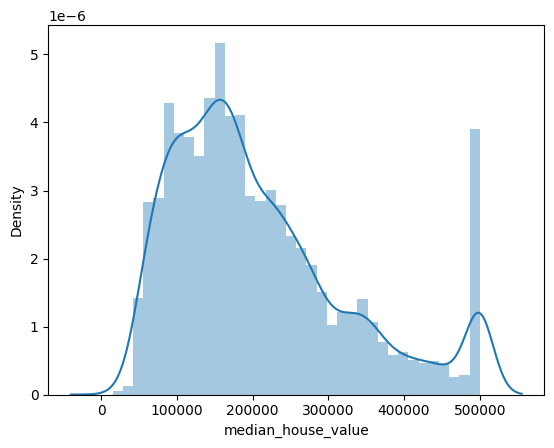

In [99]:
sns.distplot(Y_train)

Здесь есть выброс у квартир стоимостью около 500000

In [100]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model=Ridge()
model.fit(X_train[numeric_features],Y_train)
Y_pred = model.predict(X_test[numeric_features])
Y_train_pred = model.predict(X_train[numeric_features])

print("Test RMSE = %.4f" % mean_squared_error(Y_test, Y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(Y_train, Y_train_pred, squared=False))

Test RMSE = 71380.2501
Train RMSE = 73737.7469


In [101]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], Y_train, cv=10, scoring="neg_root_mean_squared_error")
cv_scores=-cv_scores
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(cv_scores))
print("R2 parameter without categorical features= %.4f" % cross_val_score(model, X_train[numeric_features], Y_train, cv=10, scoring="r2").mean())

Cross validation scores:
	 73284.2507
	79619.0794
	70927.6481
	76427.3083
	71340.8384
	74561.2296
	68493.5802
	74332.2133
	74425.2281
	74013.0773
Mean CV MSE = 73742.4453
R2 parameter without categorical features= 0.5987


In [102]:
best_constant = Y_train.mean()
print("Test RMSE with best constant = %.4f" % mean_squared_error(Y_test, best_constant * np.ones(Y_test.shape),
                                                                 squared=False))
print("Train RMSE with best constant = %.4f" % mean_squared_error(Y_train, best_constant * np.ones(Y_train.shape),
                                                                  squared=False))

Test RMSE with best constant = 113249.2816
Train RMSE with best constant = 116533.2981


In [103]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

In [104]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = Ridge()
model.fit(X_train_scaled, Y_train)
Y_pred = model.predict(X_test_scaled)
Y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % mean_squared_error(Y_test, Y_pred, squared=False))
print("Train RMSE = %.4f" % mean_squared_error(Y_train, Y_train_pred, squared=False))

Test RMSE = 71380.0367
Train RMSE = 73737.7602


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


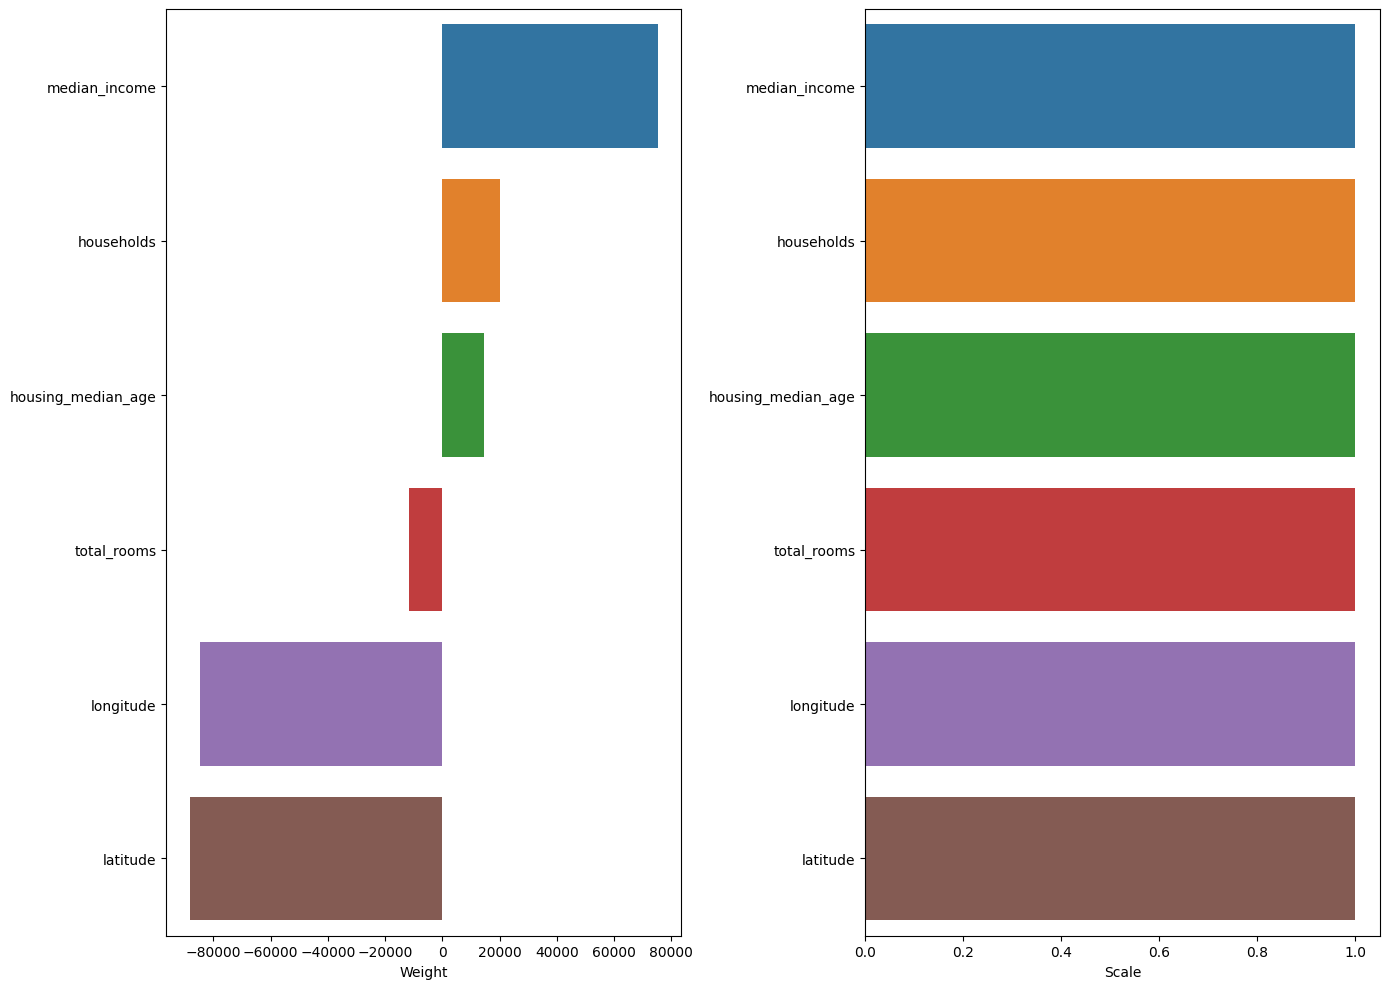

In [105]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)

Best alpha = 2.3357


Text(0, 0.5, 'CV score')

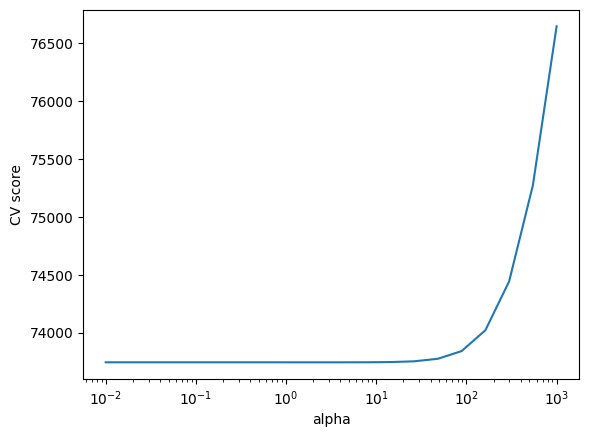

In [106]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, Y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [107]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], Y_train)
Y_pred = model.predict(X_test[numeric_features])
print("Test RMSE = %.4f" % mean_squared_error(Y_test, Y_pred, squared=False))

Test RMSE = 71379.6212


Теперь добавим в модель ккатегориальный признак, в частности, дальность от океана:

In [108]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [109]:
X_train[categorical].sample(5)

,ocean_proximity
12459,<1H OCEAN
6199,NEAR OCEAN
11906,<1H OCEAN
6786,INLAND
8415,<1H OCEAN


Улучшаем результат за счёт добавления категориального признака. Для сравнения берём результат, который получается на самом деле Теперь запустим нашу модель на тестовой выборке и оценим RMSE:

In [111]:
data_test=pd.read_csv("/kaggle/input/california-house-prices24/housing_test.csv")
x_test=data_test.drop(columns=["Id","population","total_bedrooms"])
x_test.head()

,longitude,latitude,housing_median_age,total_rooms,households,median_income,ocean_proximity
0,-122.64,38.24,40.0,1974.0,398.0,3.7917,<1H OCEAN
1,-119.05,36.09,9.0,3297.0,568.0,4.0217,INLAND
2,-116.98,32.85,12.0,3570.0,666.0,4.0882,<1H OCEAN
3,-118.42,34.20,27.0,3201.0,948.0,2.2377,<1H OCEAN
4,-118.47,34.01,41.0,2704.0,478.0,4.4211,<1H OCEAN


In [112]:
x_test.shape
x_test.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
households            float64
median_income         float64
ocean_proximity        object
dtype: object

In [113]:
categorical = list(x_test.dtypes[x_test.dtypes == "object"].index)
x_test[categorical] = x_test[categorical].fillna("NotGiven")
x_test.shape

(6192, 7)

In [114]:
y=pd.read_csv("/kaggle/input/california-house-prices24/housing_test_sample_solution.csv")
y=y.drop(columns=["Id"])
y.head()

,median_house_value
0,205311.609173
1,205311.609173
2,205311.609173
3,205311.609173
4,205311.609173


In [115]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print("Test RMSE for train = %.4f" % mean_squared_error(Y_test, Y_pred, squared=False))
print("R2 parameter = %.4f" % cross_val_score(model, X_train, Y_train, cv=10, scoring="r2").mean())
y_pred = model.predict(x_test)
print("Test RMSE for test = %.4f" % mean_squared_error(y, y_pred, squared=False))

Test RMSE for train = 70240.8200
R2 parameter = 0.6113
Test RMSE for test = 90487.5480
